# Qiskit 설치 및 수업 준비

## 로컬 환경에서 필수 패키지 설치 (https://lab.quantum-computing.ibm.com/에서는 추가로 설치할 필요가 없습니다)

최신 버젼의 Qiskit을 설치하는 것! 헷갈리신다면 다음의 순서를 따라해보세요 

1. [아나콘다 설치](https://www.anaconda.com/)

    1-1. 만약 오래된 아나콘다가 설치되어 있다면 터미널을 열어 다음의 명령어를 실행해 보세요

    `conda update -n base conda`
    
2. 환경 만들기

`conda create -n qiskit python=3.10`

3. 쥬피터 노트북 혹은 쥬피터 랩 설치

`conda install jupyter notebook` 혹은 `conda install jupyterlab`

4.  Qiskit 설치

`pip install qiskit` or `pip install qiskit[visualization]`

5. qiskit-ibm-runtime 설치

`pip install qiskit-ibm-runtime`




In [ ]:
!pip install qiskit

In [ ]:
#or 

!pip install 'qiskit[visualization]'

In [ ]:
!pip install qiskit-ibm-runtime

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table

## 실습을 위한 계정 설정 및 백엔드 확인 및 설정

실습을 위한 계정 설정을 해봅시다. 토큰은 https://quantum-computing.ibm.com/ 에서 복사해 옵니다.

https://quantum-computing.ibm.com/ 에서 노트북을 실행하는 경우 토큰 정보의 저장이 필요없습니다!

<img src="img/token.png" alt="Alternative text" width=800/>

In [33]:
# 필수 라이브러리 불러오기 

import numpy as np
import pandas as pd
from math import sqrt, pi

from qiskit import *

from qiskit_ibm_provider import IBMProvider

from qiskit.visualization import plot_error_map, plot_gate_map, plot_distribution, plot_histogram

# Plotting tools
import matplotlib.pyplot as plt

In [4]:
#IBMProvider.save_account("Your_Token", overwrite=True)
#provider = IBMProvider()

#수업을 위해 추가된 허브와 그룹, 프로젝트를 프로바이더에 설정
provider = IBMProvider(instance="ibm-q-skku/2023-quantum-lea/2023-quantum-lea")

In [5]:
provider.backends()

[<IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_algiers')>]

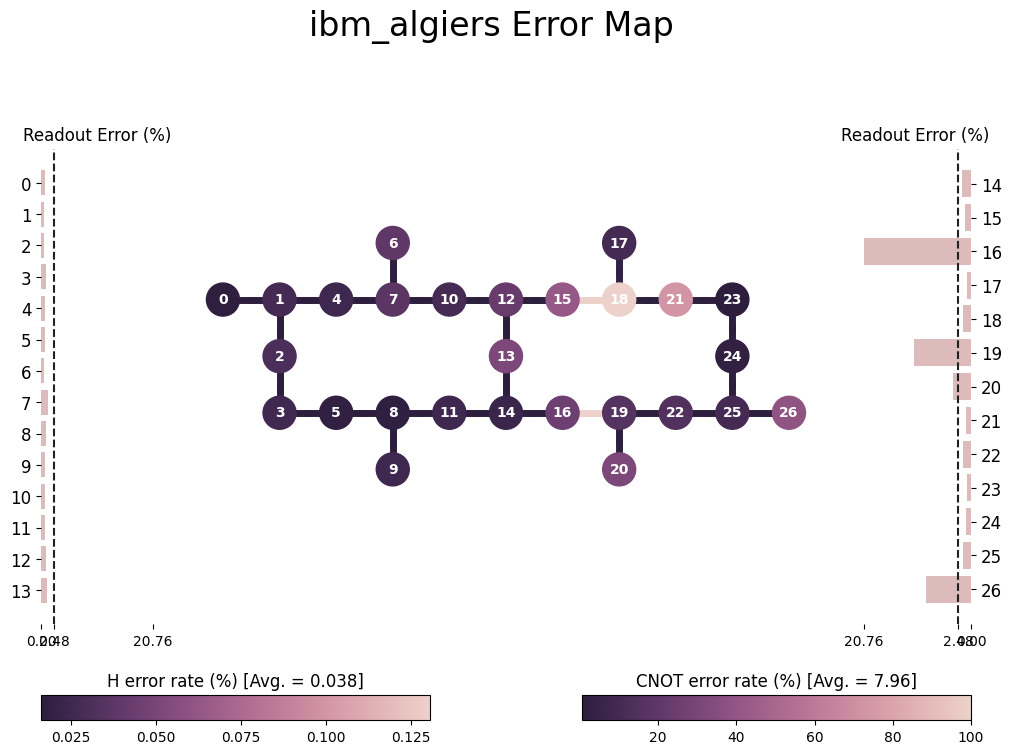

In [8]:
backend = provider.get_backend('ibm_algiers')
plot_error_map(backend)

In [ ]:
backend = provider.get_backend('ibm_sherbrooke')
plot_error_map(backend)

## 간단한 회로 만들기

이제 간단한 양자 회로를 작성하고 여러가지 방법으로 실행해 봅시다.

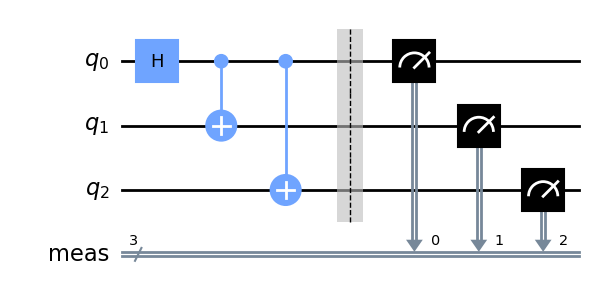

In [18]:
circ = QuantumCircuit(3)
# Add a H gate on qubit 0, putting this qubit in superposition.
circ.h(0)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1, putting
# the qubits in a Bell state.
circ.cx(0, 1)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 2, putting
# the qubits in a GHZ state.
circ.cx(0, 2)
circ.measure_all()
circ.draw('mpl')

## Circuit run without Runtime

In [ ]:
job = backend.run(transpile(circ, backend), shots=20000)
job.job_id()

In [32]:
job0 = provider.retrieve_job('cim8gujc243ejrigmle0')
#job_monitor(job0)
job0.status()

<JobStatus.DONE: 'job has successfully run'>

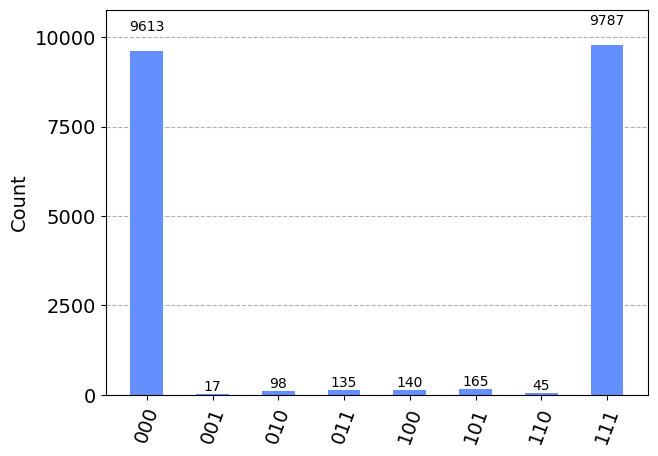

In [34]:
real_counts = job0.result().get_counts()
plot_histogram(real_counts)

## Circuit run with Runtime


In [13]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Sampler, Estimator

In [ ]:
service = QiskitRuntimeService(instance="ibm-q-skku/2023-quantum-lea/2023-quantum-lea")
service.backends()

In [37]:
runtime_backend = service.get_backend('ibm_sherbrooke')

### Use Qiskit Sampler

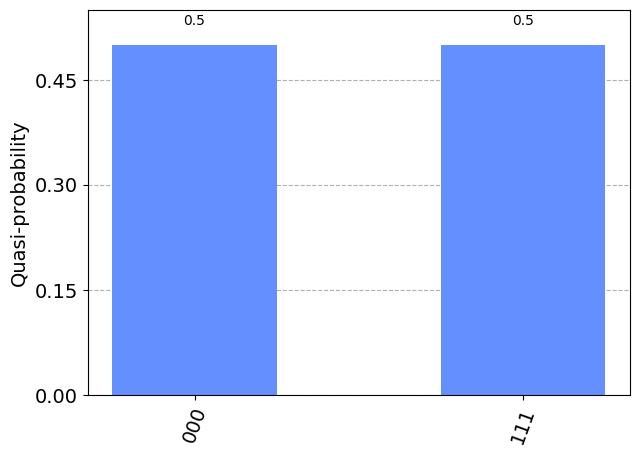

In [28]:
from qiskit.primitives import Sampler as QiskitSampler

qsampler= QiskitSampler()
qsampler_result = qsampler.run(circ).result()
plot_distribution(qsampler_result.quasi_dists[0].binary_probabilities())

### Use Sampler with real backend

이제 Sampler를 사용해 실제 백엔드에 회로를 실행해 봅시다. 좋은 결과를 얻기 위해 다음의 두가지 옵션을 설정하여 사용할 수 있습니다. 

1. optimization_level: 회로에 대해 얼마나 많은 최적화 작업을 진행할지를 결정합니다. 높은 값일 수록 더 높은 최적화가 진행됨을 의미하고 이에 따라 더 많은 session 시간이 사용됩니다. 기본 값은 1입니다.
- optimization_level = 0: no optimization
- optimization_level = 1: light optimization
- optimization_level = 2: heavy optimization
- optimization_level = 3: even heavier optimization

2. resilience_level: 에러를 얼마나 보정할지를 결정합니다. 마찬가지로 높은 값일 수록 더 정확한 결과를 얻기 위한 기술이 사용됨을 의미하며 이에 따라 더 많은 처리 시간이 소요됩니다. 기본 값은 0입니다. 
- resilience_level = 0: No error mitigation
- resilience_level = 1: Apply [M3](https://qiskit.org/ecosystem/mthree/)

In [38]:
options1 = Options()
session = Session(backend=runtime_backend)

options1.optimization_level = 3
options1.resilience_level = 1
options1.execution.shots = 20000

In [39]:
sampler = Sampler(session=session, options = options1)

sampler_job = sampler.run(circ)

In [40]:
sampler_job.job_id()

'cim8k1muepl060r8g3bg'

In [48]:
sampler_job = service.runtime.job('cim8k1muepl060r8g3bg')
sampler_job.status()

<JobStatus.DONE: 'job has successfully run'>

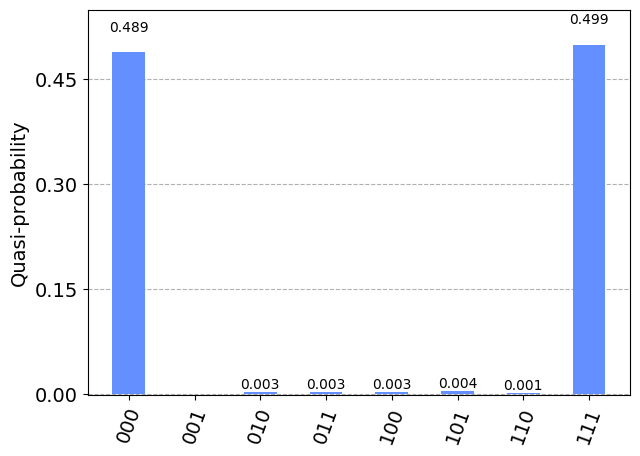

In [49]:
result = sampler_job.result()
session.close()
plot_distribution(result.quasi_dists[0].binary_probabilities())